<a href="https://colab.research.google.com/github/ataraxia404/Projeto-Deep-Learning/blob/main/codigodoTRABALHO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [1/5000], Loss: 12.0980710983, MSE: 1.7761213779
Epoch [101/5000], Loss: 11.4382381439, MSE: 1.9254189730
Epoch [201/5000], Loss: 7.9366092682, MSE: 2.2827601433
Epoch [301/5000], Loss: 2.1168332100, MSE: 2.0158839226
Epoch [401/5000], Loss: 1.0449218750, MSE: 0.8070343733
Epoch [501/5000], Loss: 0.2917646170, MSE: 0.1670747548
Epoch [601/5000], Loss: 0.0595422611, MSE: 0.0251498315
Epoch [701/5000], Loss: 0.0429450683, MSE: 0.0074054636
Epoch [801/5000], Loss: 0.0360431634, MSE: 0.0042916732
Epoch [901/5000], Loss: 0.0312721133, MSE: 0.0030656504
Epoch [1001/5000], Loss: 0.0277225915, MSE: 0.0022979563
Epoch [1101/5000], Loss: 0.0249347463, MSE: 0.0018026452
Epoch [1201/5000], Loss: 0.0226647649, MSE: 0.0014703348
Epoch [1301/5000], Loss: 0.0207770951, MSE: 0.0012329615
Epoch [1401/5000], Loss: 0.0191928521, MSE: 0.0010511203
Epoch [1501/5000], Loss: 0.0178408548, MSE: 0.0009075098
Epoch [1601/5000], Loss: 0.0166720767, MSE: 0.0007897014
Epoch [1701/5000], Loss: 0.0156642180, MS

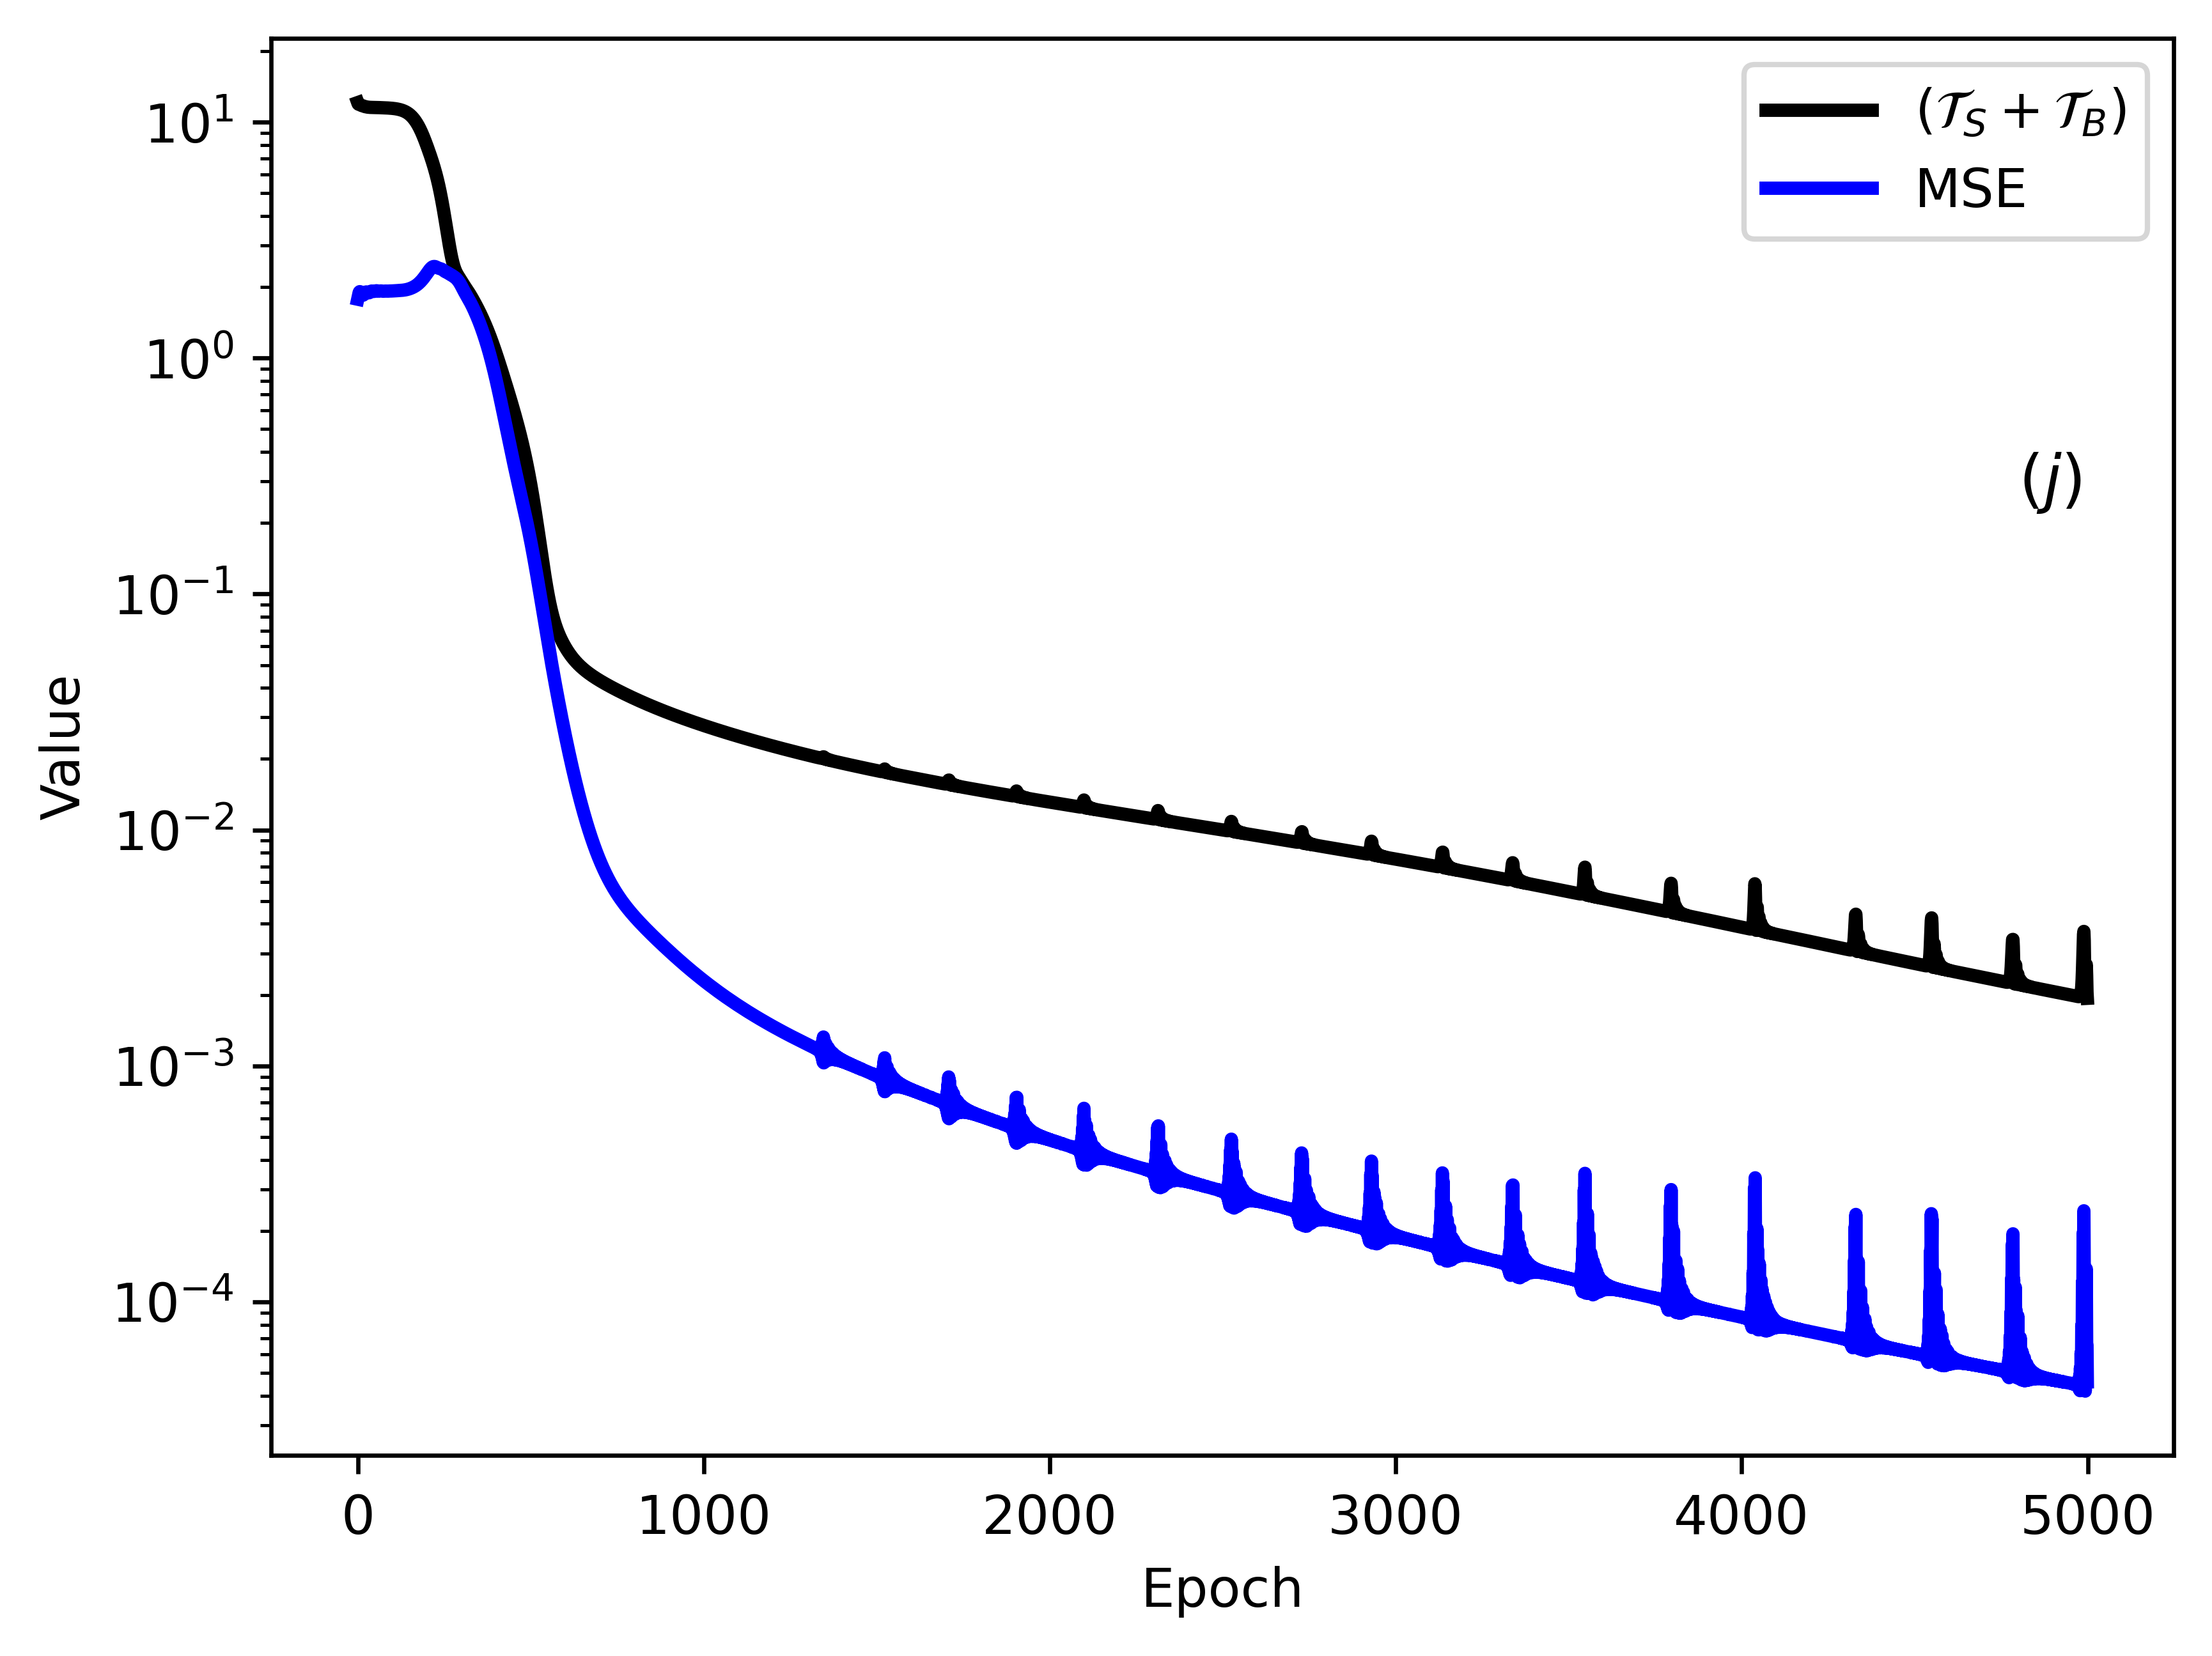

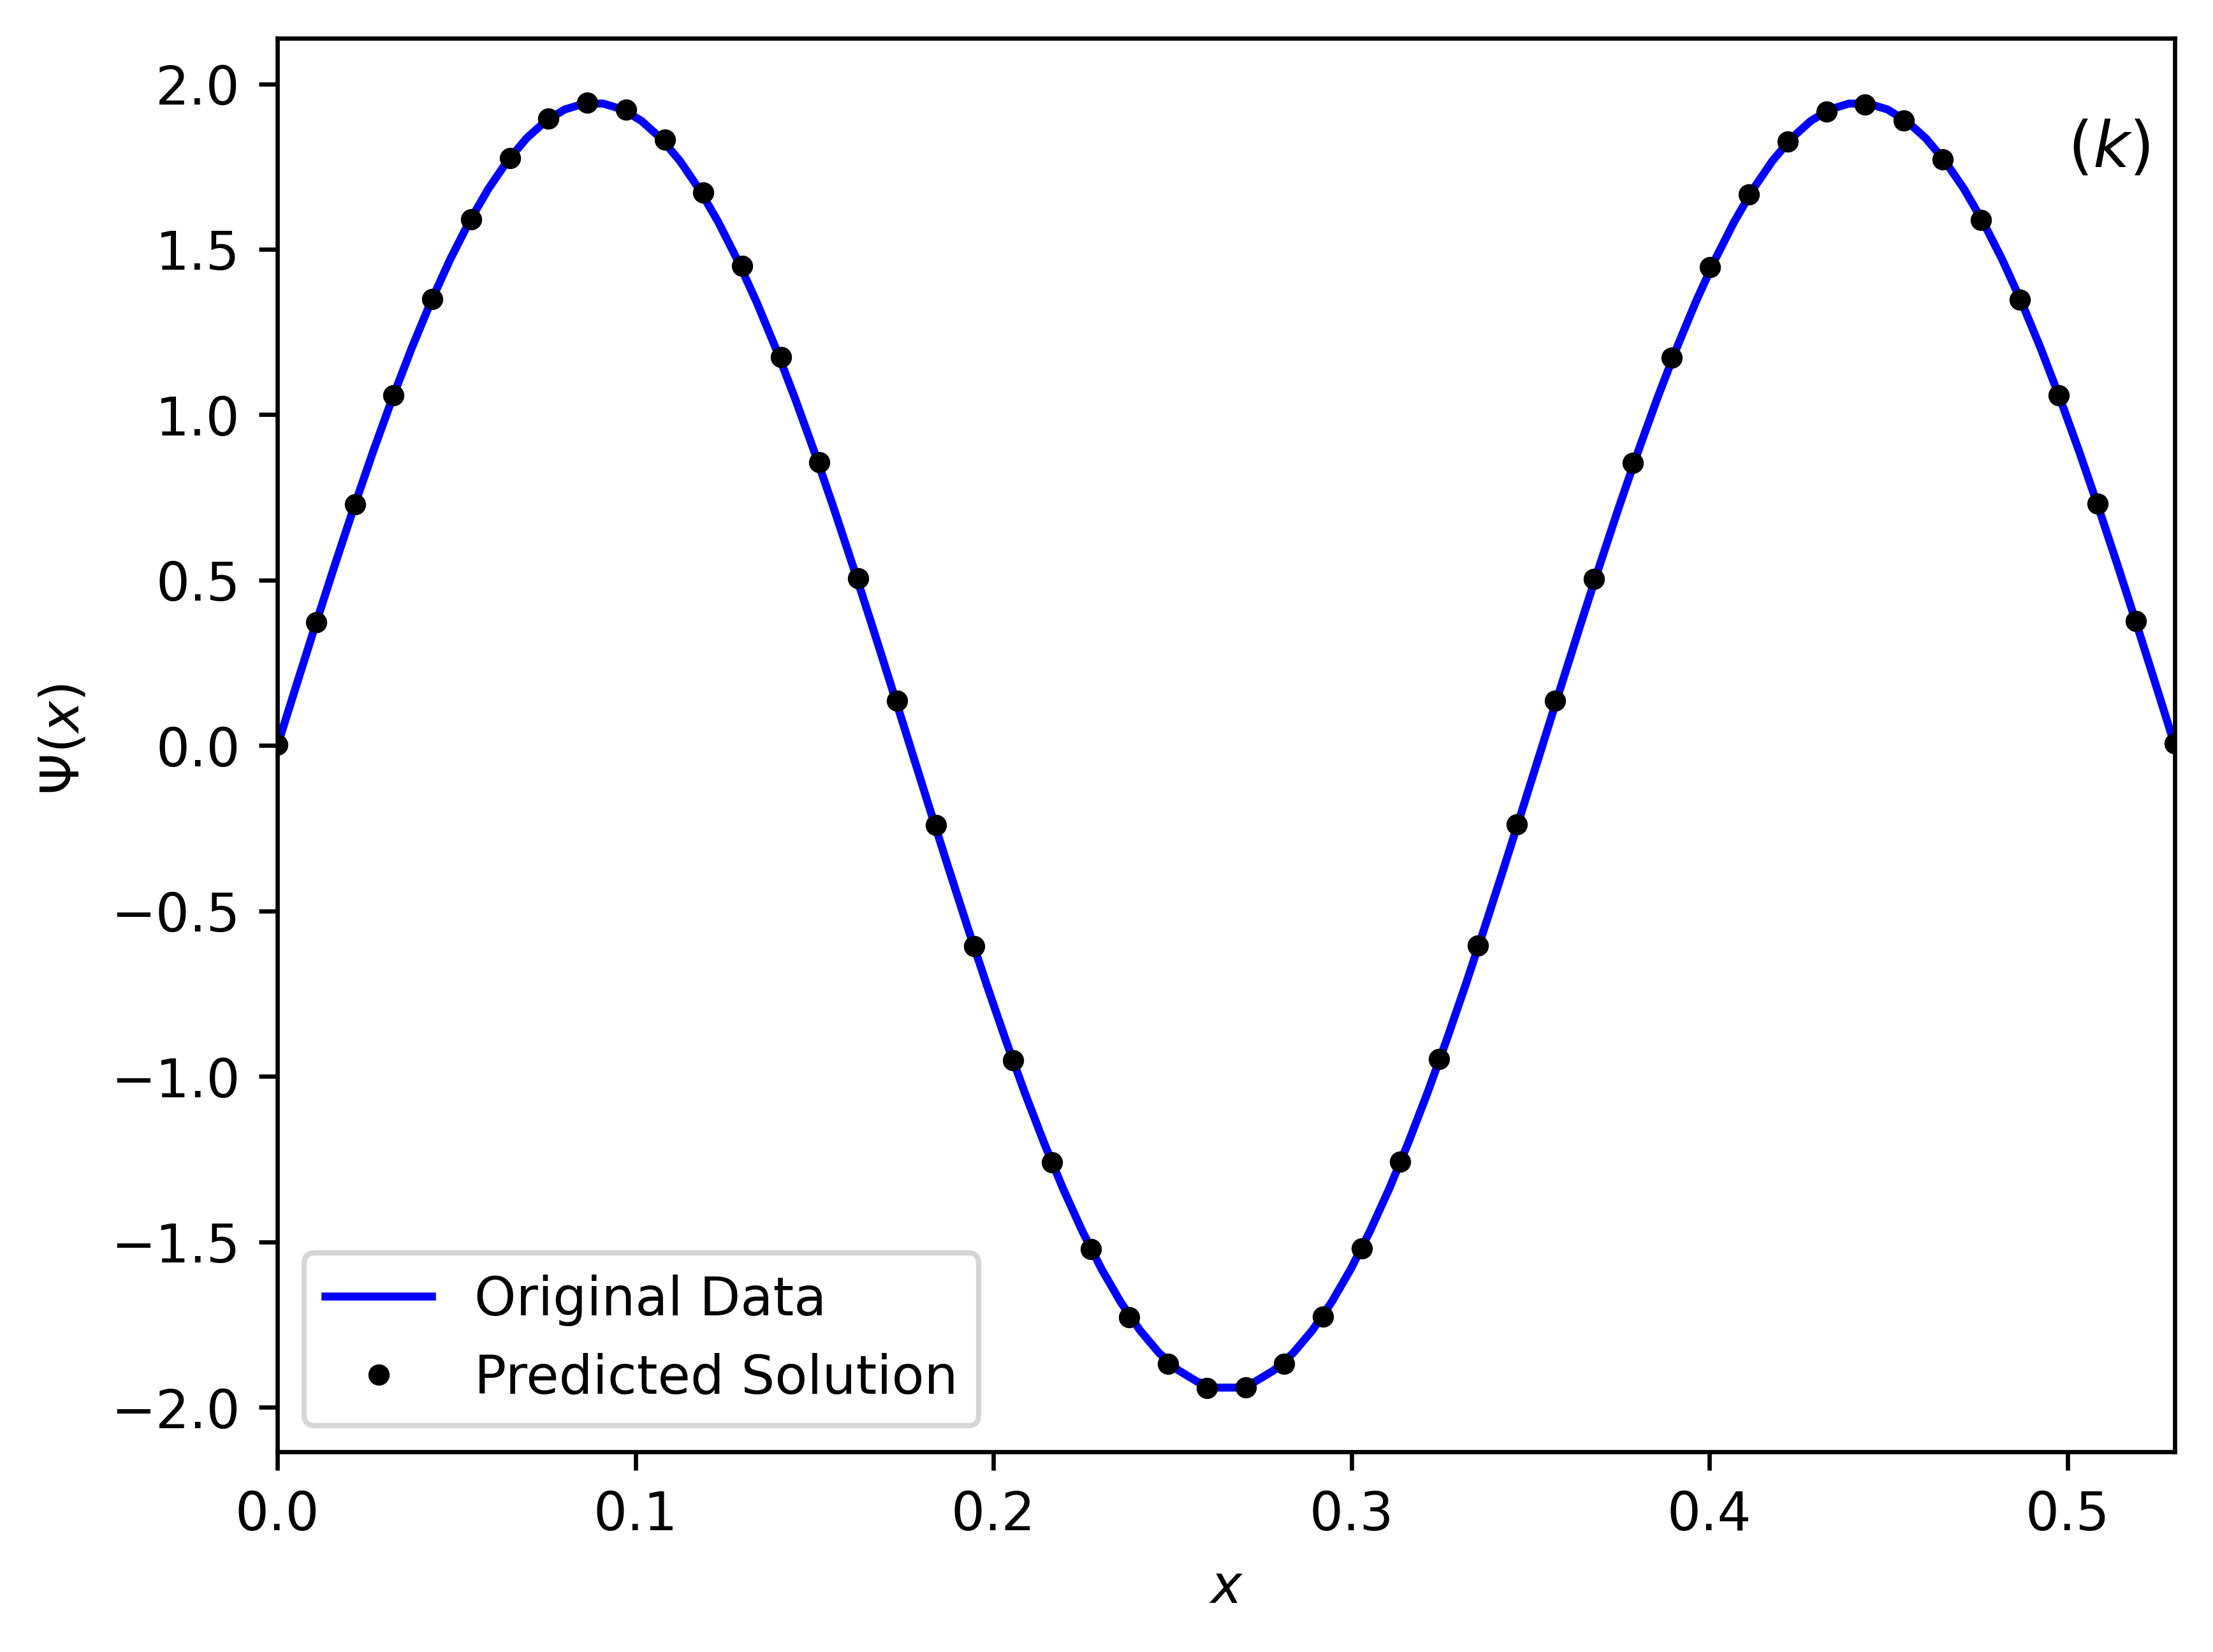

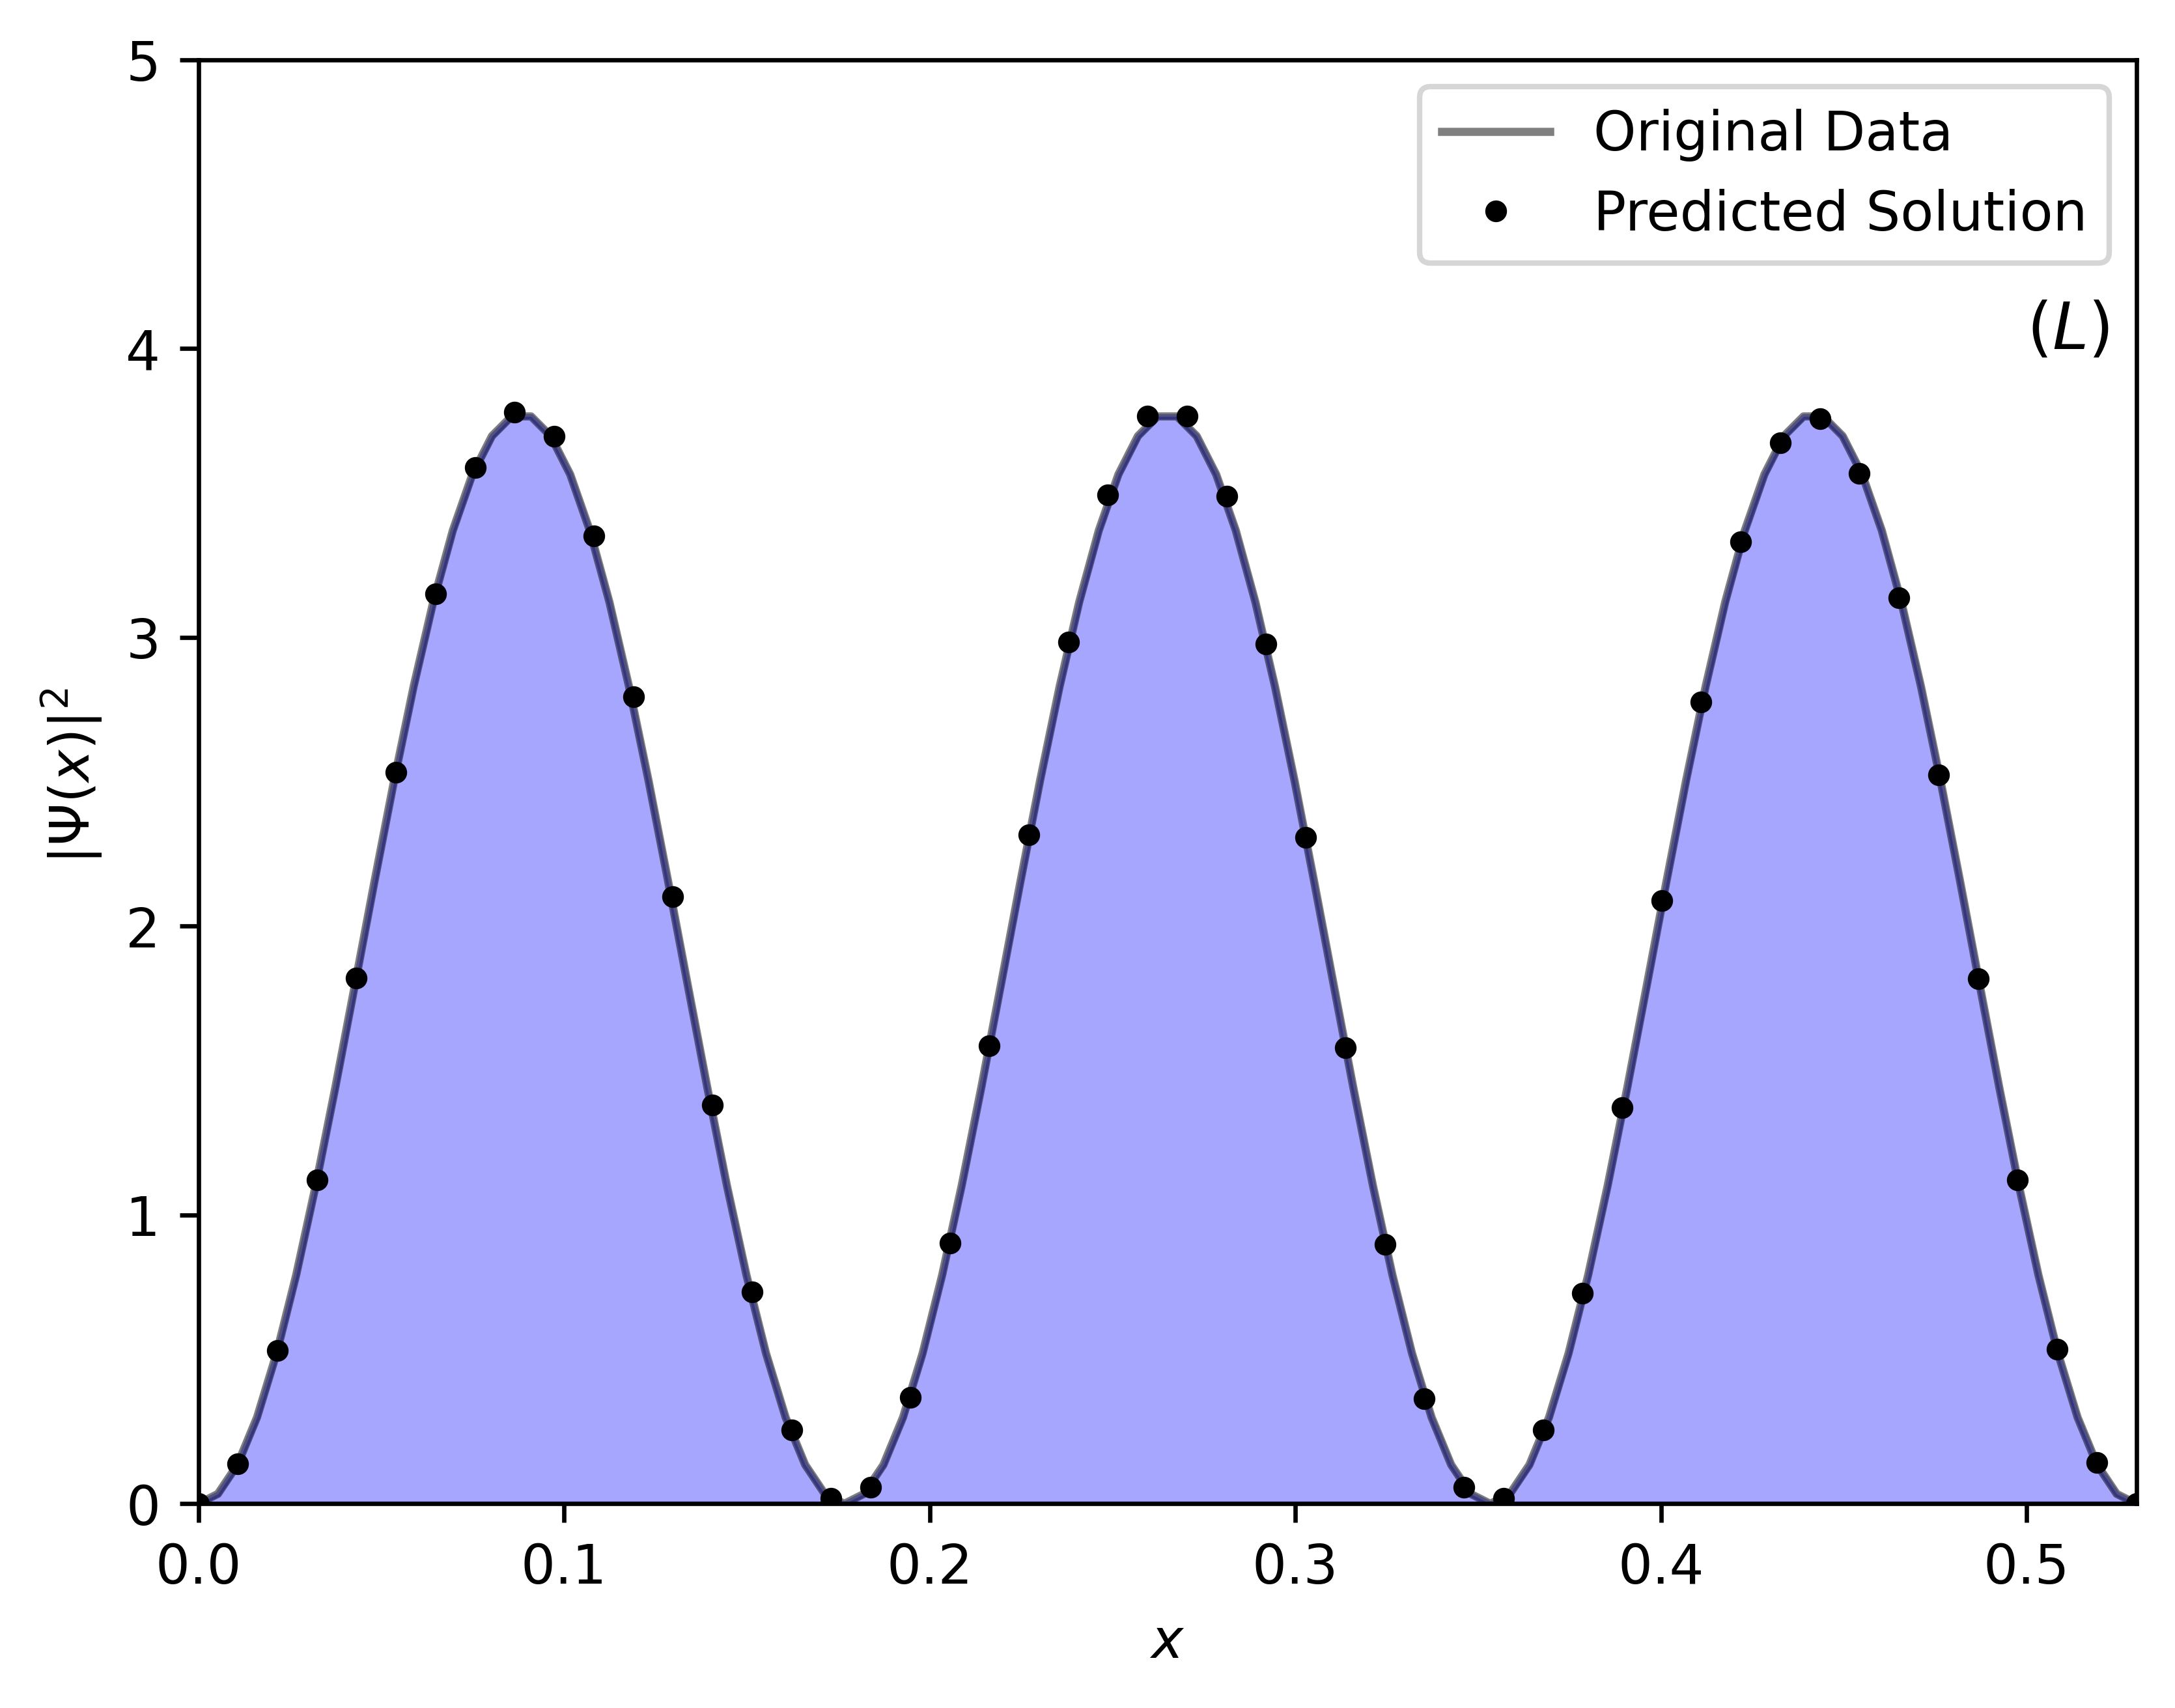

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


L = .53
n = 3
k = (n * np.pi) / L


class OdeSecond(nn.Module):
    def __init__(self):
        super(OdeSecond, self).__init__()
        self.dense1 = nn.Linear(1, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.sin(self.dense1(x))
        x = torch.sin(self.dense2(x))
        return self.dense3(x)

def train_step(model, optimizer, loss_fn, x_train, y_train, n, L):
    k = (n * np.pi) / L
    ini = (np.sqrt(2 / L)) * ((n * np.pi) / L)


    x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

    optimizer.zero_grad()


    x0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([[0.0]], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([[ini]], dtype=torch.float32)


    xL = torch.tensor([[L]], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([[0.0]], dtype=torch.float32)


    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]

    yL_NN = model(xL)


    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]


    loss = (
         10**(-3) * loss_fn(y0_NN, y0_exact) +
         10**(-4) * loss_fn(d2y_dx2_NN, -y_NN * (k ** 2)) +
         10**(-2) *loss_fn(dy_dx0_NN, dy_dx0_exact) +
         loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)

    return loss.item(), mse.item()


def plot_loss(loss_values, mse_values):
    plt.rcParams['figure.dpi'] = 600
    plt.yscale('log')
    plt.plot(loss_values, color='black', linewidth=2.5, label= '($\mathcal{T}_{S} + \mathcal{T}_{B}$)')
    plt.plot(mse_values, color='blue', linewidth=2.5, label='MSE')
    plt.text(4800, 0.25,'$(j)$', fontsize=12)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plot_solution(model, x_train, y_train):
    model.eval()
    x_test_tensor = torch.linspace(0, L, 50).unsqueeze(1)
    with torch.no_grad():
        y_pred = model(x_test_tensor).numpy()
    plt.rcParams['figure.dpi'] = 600
    plt.plot(x_train, y_train, markersize=8,  color='blue', alpha=1, label='Original Data')
    plt.plot(x_test_tensor.numpy(),  y_pred,'.', color='black',  alpha=1, label='Predicted Solution')
    plt.text(0.5, 1.75,'$(k)$', fontsize=12)
    plt.xlabel('$x$')
    plt.xlim(0, L)
    plt.ylabel(' $\Psi({x})$ ')
    plt.legend()
    plt.show()
def densidade(model, x_train, y_train):
    model.eval()
    x_test_tensor = torch.linspace(0, L, 50).unsqueeze(1)
    with torch.no_grad():
        y_pred = model(x_test_tensor).numpy()
    plt.rcParams['figure.dpi'] = 600
    plt.fill_between(x_train.flatten(), (y_train**2).flatten(), color='blue', alpha=0.35)
    plt.plot(x_train, y_train**2,  color='black', alpha=0.5, label='Original Data')
    plt.plot(x_test_tensor.numpy(),  y_pred**2, '.', color='black',  alpha=1, label='Predicted Solution')
    plt.xlabel('$x$')
    plt.text(0.5, 4,'$(L)$', fontsize=12)
    plt.ylim(0, 5)
    plt.xlim(0, L)
    plt.ylabel(' $|\Psi({x})|^2$ ')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    x_train = np.linspace(0, L, 100)[:, np.newaxis]
    y_train = np.sqrt(2 / L) * np.sin((n * np.pi * x_train) / L)

    model = OdeSecond()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    epochs = 5000
    loss_values = []
    mse_values = []
    for epoch in range(epochs):
        loss, mse = train_step(model, optimizer, loss_fn, x_train, y_train, n, L)
        loss_values.append(loss)
        mse_values.append(mse)
        if epoch % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss:.10f}, MSE: {mse:.10f}")

    print("\nModel Summary:")
    print(model)

    func_densidade = []
    func_loss = []
    func_solucao =  []

    func_loss.append(plot_loss(loss_values, mse_values))
    func_solucao.append(plot_solution(model, x_train, y_train))
    func_densidade.append(densidade(model, x_train, y_train))
